## Polarity is all you need to learn and transfer faster
This notebook is a tutorial for reproducing the computer vision results in **Polarity is all you need to learn and transfer faster**.  
* Experimental data used in this notebook can be downloaded from OSF following this anonymized [link](https://osf.io/f9wtc/?view_only=61b71c37306a41209da0eb1c35dbf8d0)
* Pre-trained AlexNet weights were obtainer from [here](https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/). Please download the tf2 version before running the experiments code
* All experiments and analysis were performed within the following docker environment, which could be setup as following. 
```setup
docker build -t weightpolarity .
docker run --gpus all -v ${PWD}:/workspace --name weightpolarity weightpolarity
```

## Computer vision experiments

## Experiments

* The experiments are set up to run in background in paralell. 
* You may choose to change the training sample size (sample_size_list) and epoch number (num_epoch) configurations in batchcis.py. The current setup is for paper reproduction. 
* You are suggested to run below lines in command line. 

In [ ]:
! python batchcis.py --num_run=20 --baseFName="fashion_mnist" --num_epoch=100 --ckpt_freq=0 --doRandInit=2 --num_gpu=1
! python batchcis.py --num_run=20 --baseFName="cifar10" --num_epoch=100 --ckpt_freq=0 --doRandInit=2 --num_gpu=1

### Consolidate all data
* Below two cells, will collect all experimental data into "epoch_acc_loss.pkl" file which are accessible from the above OSF [link](https://osf.io/f9wtc/?view_only=61b71c37306a41209da0eb1c35dbf8d0). The first one is for fashion_mnist, second is for cifar10

In [ ]:
! python doPlots.py --num_run=20 --baseFName='fashion_mnist' --resetType='posRand' --numEpoch=100

In [ ]:
! python doPlots.py --num_run=20 --baseFName='cifar10' --resetType='posRand' --numEpoch=100

## Analysis

### 1.Preparation - load necessary packages and helper functions

In [2]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import matplotlib as matplotlib

In [3]:
# white background
plt.rcParams.update({
    "lines.color": "black",
    "patch.edgecolor": "black",
    "text.color": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "lightgray"})

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from plots import dict_to_query, plot_median_plus_example, simpleaxis, plot_sem, plot_diff_plus_mannwhitneyu

In [6]:
def paint_color(x, y):
    if x > 0:
        if y > 0:
            return np.array(3)
        else:
            return np.array(2)
    else:
        if y > 0:
            return np.array(1)
        else:
            return np.array(0)
np_paint_color = np.vectorize(paint_color, otypes = [np.ndarray])

### 2.Load Data
* Here, we will use experiment data presented in the manuscript. They are presented in the main text, each experiment was ran for 20 repeats

In [45]:
metrics = np.load('epoch_acc_loss.pkl', allow_pickle=True)

In [60]:
# Decided to still mannually define here so that it can be cross-checked with the loaded data
doWeightFreeze_list = [True, False]
sample_size_list = np.concatenate(([100,250,500,750], np.arange(1,7)*1000)) # fashion-MNIST
# sample_size_list = np.array([100,250,500,750,1000,2500,5000,10000,25000,50000]) # cifar10
networkType_list = ['pretrained', 'vanilla', 'finetune']

numRun = 20 
resetType_list = ['posRand']

In [47]:
print(metrics.shape)
print(metrics['train_acc'][0].shape)

(24, 11)
(2, 3)


In [50]:
all_nan_loci = np.where([np.isnan(metric).any() for metric in metrics['validation_acc']])
metrics.loc[all_nan_loci]

,resetType,networkType,train_sample,num_epoch,typeStr,train_acc,train_loss,validation_acc,validation_loss,pre_train_acc,pre_validation_acc


In [51]:
distinct_clr_5 = ['b', 'g', [0.8775005622769879, 0.23839973362704925, 0.9581301298028325], [0,1,1], [1,.5,0]] # I'll settle with this! 

### 3.**DATA: Statistical Efficiency** - Figure 2 & 3 first column

#### Load functions

In [52]:
def get_converge_epoch(x):
    epoch_num = np.squeeze(np.where(x == np.amin(x)))
    if not len(epoch_num.shape)==0:
        epoch_num = epoch_num[0]
    return epoch_num

In [53]:
def get_acc_at_conver(val_acc, val_loss):
    # both are matrices with rows as run
    epoch_at_conver = np.apply_along_axis(get_converge_epoch, 1, val_loss)
    acc_at_conver = np.squeeze(np.take_along_axis(val_acc, np.expand_dims(epoch_at_conver, axis=1), axis=1))
    # print(epoch_at_conver.shape)
    # print(acc_at_conver.shape)    
    return acc_at_conver, epoch_at_conver

In [54]:
def get_conver(metrics, doWeightFreeze_list, resetType_list, networkType, numRun):
    conver = pd.DataFrame(index=range(len(doWeightFreeze_list)*len(resetType_list)), columns=["typeStr", "resetType", "networkType", "acc", "epoch"])

    for ridx, resetType in enumerate(resetType_list):
        for didx, doWeightFreeze in enumerate(doWeightFreeze_list):
            df_loc = ridx*len(doWeightFreeze_list)+didx
            if doWeightFreeze:
                typeStr = 'freeze'
                typeStr_dict = '\'freeze\''
            else:
                typeStr = 'liquid'
                typeStr_dict = '\'liquid\''
            conver['typeStr'][df_loc] = typeStr
            conver['resetType'][df_loc] = resetType
            conver['networkType'][df_loc] = networkType

            # get different sample sizes into list
            page_dict = {'networkType':'\''+ networkType +'\'', 'typeStr':typeStr_dict, 'resetType':'\''+ resetType +'\''}
            val_loss = metrics.query(dict_to_query(page_dict))['validation_loss'].tolist()
            val_acc = metrics.query(dict_to_query(page_dict))['validation_acc'].tolist()
            # print(val_acc[0].shape)

            acc_at_conver = np.empty(shape=(len(sample_size_list), numRun))
            epoch_at_conver = np.empty(shape=(len(sample_size_list), numRun))
            for idx, (this_val_loss, this_val_acc) in enumerate(zip(val_loss, val_acc)):
                this_acc_at_conver, this_epoch_at_conver = get_acc_at_conver(this_val_acc, this_val_loss)
                acc_at_conver[idx, :] = this_acc_at_conver
                epoch_at_conver[idx, :] = this_epoch_at_conver
                # print('sample size %d is done' % idx)
            conver['acc'][df_loc] = np.transpose(acc_at_conver)
            conver['epoch'][df_loc] = np.transpose(epoch_at_conver)
    return conver

In [55]:
def get_stack_flops(flops, typeStr, acc, colName, networkType_list):
    return np.squeeze(np.stack([np.stack(flops.query(dict_to_query({'typeStr':'\''+typeStr+'\'', 'acc':acc, 'networkType':'\''+networkType +'\''}))[colName].tolist()) for networkType in networkType_list]))

In [56]:
def get_stack_conver(conver, typeStr, colName, networkType_list):
    return np.squeeze(np.stack([np.stack(conver.query(dict_to_query({'typeStr':'\''+typeStr+'\'', 'networkType':'\''+networkType +'\''}))[colName].tolist()) for networkType in networkType_list]))

#### Below cell plot for Figure 2 first column

Freeze IN-Polarity
[88.59999999 86.23000048 78.5450004  77.76499949]
Fluid IN-Polarity
[89.70500007 83.94000009 84.19999965 86.82500012]
[89.99999985 89.99999985 88.37999962 84.35999975]
[89.99999985 89.99999985 86.85999997 89.99999985]


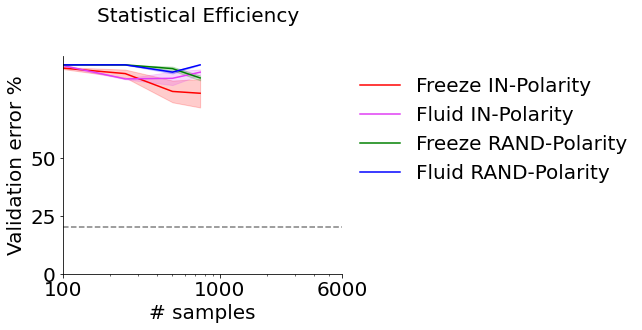

In [63]:
fontsize=20
resetType_list = ['posRand']
for resetType in resetType_list:
    conver_smart = get_conver(metrics, doWeightFreeze_list, resetType_list, 'pretrained', numRun)
    conver_dumb = get_conver(metrics, doWeightFreeze_list, resetType_list, 'vanilla', numRun)
    conver_finetune = get_conver(metrics, doWeightFreeze_list, resetType_list, 'finetune', numRun)
    fig = plt.figure(figsize=(5,4))

    thisAx = plt.gca()
    doExample = False
    x_coord = np.array(sample_size_list)
    xlim=[np.min(x_coord), np.max(x_coord)]
    ylim=0
    color_list = ['r'] + [distinct_clr_5[ii] for ii in [2,1,0]]

    for didx, doWeightFreeze in enumerate(doWeightFreeze_list):
        if doWeightFreeze:
            typeStr = 'Freeze IN-Polarity'
            typeStr_dict = '\'freeze\''
        else:
            typeStr = 'Fluid IN-Polarity'
            typeStr_dict = '\'liquid\''
        
        print(typeStr)
        x_mat = conver_smart.query(dict_to_query({'typeStr':typeStr_dict, 'resetType':'\''+resetType+'\''}))['acc'].tolist()[0]
        plot_median_plus_example((1-x_mat)*100, x_coord, ylim, xlim, typeStr, doExample, thisAx, color=color_list[didx])
        # plot_sem((1-x_mat)*100, x_coord, ylim, xlim, typeStr, thisAx, color=color_list[didx])

    x_mat = conver_dumb.query(dict_to_query({'typeStr':'\'freeze\'', 'resetType':'\''+resetType+'\''}))['acc'].tolist()[0]
    plot_median_plus_example((1-x_mat)*100, x_coord, ylim, xlim, 'Freeze RAND-Polarity', doExample, thisAx, color=color_list[2])
    # plot_sem((1-x_mat)*100, x_coord, ylim, xlim, 'Freeze-uninformed', thisAx, color=color_list[2])

    x_mat = conver_dumb.query(dict_to_query({'typeStr':'\'liquid\'', 'resetType':'\''+resetType+'\''}))['acc'].tolist()[0]
    plot_median_plus_example((1-x_mat)*100, x_coord, ylim, xlim, 'Fluid RAND-Polarity', doExample, thisAx, color=color_list[3])

    # plt.plot([100,50000], [50,50], '--', color=[.5,.5,.5])
    plt.plot([100,6000], [20,20], '--', color=[.5,.5,.5])

    simpleaxis(thisAx)
    thisAx.set_xscale('log')
    thisAx.set_xticks([100,1000,6000], ['%d' % x for x in [100,1000,6000]], fontsize=fontsize)
    thisAx.set_yticks([0,25,50], ['%d' % x for x in [0,25,50]], fontsize=fontsize)
    # thisAx.set_xticks([100,5000,50000], ['%d' % x for x in [100,5000,50000]], fontsize=fontsize)
    # thisAx.set_yticks([0,50,100], ['%d' % x for x in [0,50,100]], fontsize=fontsize)
    # thisAx.set_ylim([0,40])
    thisAx.set_xlabel('# samples', fontsize=fontsize)
    thisAx.set_ylabel('Validation error %', fontsize=fontsize)
    handles, labels = thisAx.get_legend_handles_labels()
    fig.text(0.5,1,'Statistical Efficiency', ha='center', fontsize=fontsize)

    by_label = {labels[i]:handles[i] for i in [0,1,2,3]}
    lgd = thisAx.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1,.99), fancybox=True, framealpha=0, fontsize=fontsize)
    plt.savefig(os.path.join(os.getcwd(), 'sample_efficiency.png'), dpi=400, bbox_inches = 'tight')

#### Below cell plot for Supp Figure A.3 first column

Freeze
[88.59999999 86.23000048 78.5450004  77.76499949]
[88.97500001 89.70500007 89.99499977 90.11499994]
Fluid
[89.70500007 83.94000009 84.19999965 86.82500012]
[85.72000004 85.24499983 87.53500022 85.69000028]


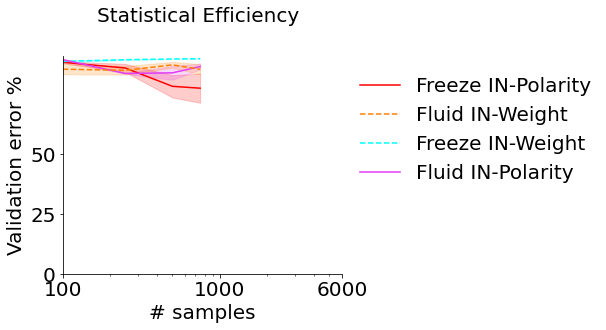

In [64]:
fontsize=20
resetType_list = ['posRand']
for resetType in resetType_list:
    conver_smart = get_conver(metrics, doWeightFreeze_list, resetType_list, 'pretrained', numRun)
    conver_dumb = get_conver(metrics, doWeightFreeze_list, resetType_list, 'vanilla', numRun)
    conver_finetune = get_conver(metrics, doWeightFreeze_list, resetType_list, 'finetune', numRun)
    fig = plt.figure(figsize=(5,4))

    thisAx = plt.gca()
    doExample = False
    x_coord = np.array(sample_size_list)
    xlim=[np.min(x_coord), np.max(x_coord)]
    ylim=0
    color_list = ['r'] + [distinct_clr_5[ii] for ii in [2,3,4]]

    for didx, doWeightFreeze in enumerate(doWeightFreeze_list):
        if doWeightFreeze:
            typeStr = 'Freeze'
            typeStr_dict = '\'freeze\''
        else:
            typeStr = 'Fluid'
            typeStr_dict = '\'liquid\''
        
        print(typeStr)
        x_mat = conver_smart.query(dict_to_query({'typeStr':typeStr_dict, 'resetType':'\''+resetType+'\''}))['acc'].tolist()[0]
        plot_median_plus_example((1-x_mat)*100, x_coord, ylim, xlim, typeStr+' IN-Polarity', doExample, thisAx, color=color_list[didx])
        # plot_sem((1-x_mat)*100, x_coord, ylim, xlim, typeStr, thisAx, color=color_list[didx])

        x_mat = conver_finetune.query(dict_to_query({'typeStr':typeStr_dict, 'resetType':'\''+resetType+'\''}))['acc'].tolist()[0]
        plot_median_plus_example((1-x_mat)*100, x_coord, ylim, xlim, typeStr+' IN-Weight', doExample, thisAx, color=color_list[didx+2], lineType = '--')
        # plot_sem((1-x_mat)*100, x_coord, ylim, xlim, typeStr, thisAx, color=color_list[didx], lineType = '--')

    # plt.plot([100,50000], [50,50], '--', color=[.5,.5,.5])
    # plt.plot([100,6000], [20,20], '--', color=[.5,.5,.5])

    simpleaxis(thisAx)
    thisAx.set_xscale('log')
    thisAx.set_xticks([100,1000,6000], ['%d' % x for x in [100,1000,6000]], fontsize=fontsize)
    thisAx.set_yticks([0,25,50], ['%d' % x for x in [0,25,50]], fontsize=fontsize)
    # thisAx.set_xticks([100,5000,50000], ['%d' % x for x in [100,5000,50000]], fontsize=fontsize)
    # thisAx.set_yticks([0,50,100], ['%d' % x for x in [0,50,100]], fontsize=fontsize)
    # thisAx.set_ylim([0,40])
    thisAx.set_xlabel('# samples', fontsize=fontsize)
    thisAx.set_ylabel('Validation error %', fontsize=fontsize)
    handles, labels = thisAx.get_legend_handles_labels()
    fig.text(0.5,1,'Statistical Efficiency', ha='center', fontsize=fontsize)

    by_label = {labels[i]:handles[i] for i in [0,3,1,2]}
    lgd = thisAx.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1,.99), fancybox=True, framealpha=0, fontsize=fontsize)
    plt.savefig(os.path.join(os.getcwd(), 'sample_efficiency_finetune.png'), dpi=400, bbox_inches = 'tight')

#### Below cell plot for Figure 3 first column

In [65]:
import importlib
import plots
importlib.reload(plots)
from plots import plot_diff_plus_mannwhitneyu

In [66]:
from scipy.stats import mannwhitneyu

[88.59999999 86.23000048 78.5450004  77.76499949]
[89.70500007 83.94000009 84.19999965 86.82500012]
[88.59999999 86.23000048 78.5450004  77.76499949]
[89.99999985 89.99999985 86.85999997 89.99999985]
[88.59999999 86.23000048 78.5450004  77.76499949]
[88.97500001 89.70500007 89.99499977 90.11499994]
[88.59999999 86.23000048 78.5450004  77.76499949]
[85.72000004 85.24499983 87.53500022 85.69000028]


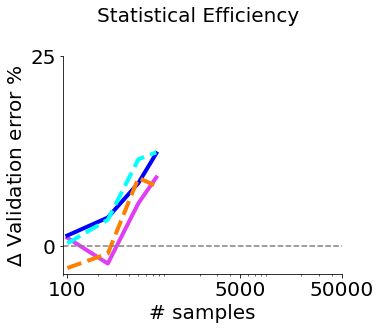

In [67]:
fontsize=20
resetType_list = ['posRand']
for resetType in resetType_list:
    conver_smart = get_conver(metrics, doWeightFreeze_list, resetType_list, 'pretrained', numRun)
    conver_dumb = get_conver(metrics, doWeightFreeze_list, resetType_list, 'vanilla', numRun)
    conver_finetune = get_conver(metrics, doWeightFreeze_list, resetType_list, 'finetune', numRun)

    doExample = False
    x_coord = np.array(sample_size_list)
    xlim=[np.min(x_coord), np.max(x_coord)]
    ylim=0
    color_list = [distinct_clr_5[ii] for ii in [0,2,3,4]]

    ######### To correct for multiple comparisons
    plist = []
    base_line = conver_smart.query(dict_to_query({'typeStr':'\'freeze\'', 'resetType':'\''+resetType+'\''}))['acc'].tolist()[0]

    y_mat = conver_smart.query(dict_to_query({'typeStr':'\'liquid\'', 'resetType':'\''+resetType+'\''}))['acc'].tolist()[0]
    test_stat = mannwhitneyu((1-base_line)*100, (1-y_mat)*100, axis = 0, alternative = 'two-sided', nan_policy = 'omit') #
    plist.append(test_stat.pvalue)

    y_mat = conver_dumb.query(dict_to_query({'typeStr':'\'liquid\'', 'resetType':'\''+resetType+'\''}))['acc'].tolist()[0]
    test_stat = mannwhitneyu((1-base_line)*100, (1-y_mat)*100, axis = 0, alternative = 'two-sided', nan_policy = 'omit') #
    plist.append(test_stat.pvalue)

    y_mat = conver_finetune.query(dict_to_query({'typeStr':'\'freeze\'', 'resetType':'\''+resetType+'\''}))['acc'].tolist()[0]
    test_stat = mannwhitneyu((1-base_line)*100, (1-y_mat)*100, axis = 0, alternative = 'two-sided', nan_policy = 'omit') #
    plist.append(test_stat.pvalue)

    y_mat = conver_finetune.query(dict_to_query({'typeStr':'\'liquid\'', 'resetType':'\''+resetType+'\''}))['acc'].tolist()[0]
    test_stat = mannwhitneyu((1-base_line)*100, (1-y_mat)*100, axis = 0, alternative = 'two-sided', nan_policy = 'omit') #
    plist.append(test_stat.pvalue)

    pmat = np.stack(plist)
    sort_idx = np.argsort(pmat, axis=0)
    revert_idx = np.argsort(sort_idx, axis=0)
    pvallist = 0.05/np.arange(4,0,-1)
    # print(pvallist)
    sigmat = np.stack([np.cumprod(row[s_idx]<pvallist)[r_idx].astype(bool) for row, s_idx, r_idx in zip(pmat.T, sort_idx.T, revert_idx.T)], axis=1)
        # print(row[s_idx])
        # print(siglist)
        # print(row)
        # print(siglist[r_idx])
    ##########
    
    fig = plt.figure(figsize=(5,4))
    thisAx = plt.gca()

    base_line = conver_smart.query(dict_to_query({'typeStr':'\'freeze\'', 'resetType':'\''+resetType+'\''}))['acc'].tolist()[0]

    y_mat = conver_smart.query(dict_to_query({'typeStr':'\'liquid\'', 'resetType':'\''+resetType+'\''}))['acc'].tolist()[0]
    plot_diff_plus_mannwhitneyu((1-base_line)*100, (1-y_mat)*100, x_coord, ylim, xlim, 'Fluid IN-Polarity', thisAx, siglist = sigmat[0,:], color=color_list[1], linewidth=4)

    y_mat = conver_dumb.query(dict_to_query({'typeStr':'\'liquid\'', 'resetType':'\''+resetType+'\''}))['acc'].tolist()[0]
    plot_diff_plus_mannwhitneyu((1-base_line)*100, (1-y_mat)*100, x_coord, ylim, xlim, 'Fluid RAND-Polarity', thisAx, siglist = sigmat[1,:], color=color_list[0], linewidth=4)

    y_mat = conver_finetune.query(dict_to_query({'typeStr':'\'freeze\'', 'resetType':'\''+resetType+'\''}))['acc'].tolist()[0]
    plot_diff_plus_mannwhitneyu((1-base_line)*100, (1-y_mat)*100, x_coord, ylim, xlim, 'Freeze IN-Weight', thisAx, siglist = sigmat[2,:], color=color_list[2], linewidth=4, lineType = '--')

    y_mat = conver_finetune.query(dict_to_query({'typeStr':'\'liquid\'', 'resetType':'\''+resetType+'\''}))['acc'].tolist()[0]
    plot_diff_plus_mannwhitneyu((1-base_line)*100, (1-y_mat)*100, x_coord, ylim, xlim, 'Fluid IN-Weight', thisAx, siglist = sigmat[3,:], color=color_list[3], linewidth=4, lineType = '--')

    plt.plot([90,50000], [0,0], '--', color=[.5,.5,.5])
    # plt.plot([90,6000], [0,0], '--', color=[.5,.5,.5])

    simpleaxis(thisAx)
    thisAx.set_xscale('log')
    # thisAx.set_xticks([100,1000,6000], ['%d' % x for x in [100,1000,6000]], fontsize=fontsize)
    # thisAx.set_yticks([0,10], ['%d' % x for x in [0,10]], fontsize=fontsize)
    # thisAx.set_xlim([90,6000])
    thisAx.set_xticks([100,5000,50000], ['%d' % x for x in [100,5000,50000]], fontsize=fontsize)
    thisAx.set_yticks([0,25], ['%d' % x for x in [0,25]], fontsize=fontsize)
    thisAx.set_xlim([90,50000])
    # thisAx.set_ylim([0,40])
    thisAx.set_xlabel('# samples', fontsize=fontsize)
    thisAx.set_ylabel('$\Delta$ Validation error %', fontsize=fontsize)
    handles, labels = thisAx.get_legend_handles_labels()
    fig.text(0.5,1,'Statistical Efficiency', ha='center', fontsize=fontsize)

    # by_label = {labels[i]:handles[i] for i in [2,1,0]}
    # lgd = thisAx.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1,.99), fancybox=True, framealpha=0, fontsize=fontsize)
    plt.savefig(os.path.join(os.getcwd(), 'sample_efficiency_test.png'), dpi=400, bbox_inches = 'tight')

### 4.**TIME: Computational Efficiency** - Figure 2 & 3 third column

#### Load func

In [68]:
def get_learnt_epoch(x, cutoff):
    epoch_num = np.squeeze(np.where(x >= cutoff))
    if not len(epoch_num.shape) == 0: # only has single element
        if epoch_num.shape[0]==0:
            epoch_num = np.NaN
        else:
            epoch_num = epoch_num[0].astype(np.float64)
    else:
        epoch_num = epoch_num.astype(np.float64)
    return epoch_num

In [69]:
def get_flops(metrics, doWeightFreeze_list, acc_cutoff_list, resetType_list, networkType, numRun):
    flops = pd.DataFrame(index=range(len(doWeightFreeze_list)*len(acc_cutoff_list)*len(resetType_list)), columns=["typeStr", "resetType", "networkType", "acc", "epoch", "flops"])
    counter = 0

    for resetType in resetType_list:
        for acc_cutoff in acc_cutoff_list:
            for doWeightFreeze in doWeightFreeze_list:
                if doWeightFreeze:
                    typeStr = 'freeze'
                    typeStr_dict = '\'freeze\''
                else:
                    typeStr = 'liquid'
                    typeStr_dict = '\'liquid\''
                flops['typeStr'][counter] = typeStr
                flops['acc'][counter] = acc_cutoff
                flops['resetType'][counter] = resetType
                flops['networkType'][counter] = networkType

                # get different sample sizes into list
                page_dict = {'networkType':'\'' + networkType + '\'', 'typeStr':typeStr_dict, 'resetType':'\'' + resetType + '\''} #, 'train_sample':sample_size_list[8]
                val_acc = metrics.query(dict_to_query(page_dict))['validation_acc'].tolist()
                # print(val_acc[0].shape)

                epoch_at_learnt = np.empty(shape=(len(sample_size_list), numRun), dtype=np.float64)
                for idx, this_val_acc in enumerate(val_acc):
                    this_epoch_at_learnt = np.apply_along_axis(get_learnt_epoch, 1, this_val_acc, acc_cutoff)
                    epoch_at_learnt[idx, :] = np.squeeze(this_epoch_at_learnt)
                    del this_epoch_at_learnt
                flops['epoch'][counter] = np.transpose(epoch_at_learnt)
                flops['flops'][counter] = flops['epoch'][counter]*62388354 # hSize_infocus*3
                counter+=1
        # print('@acc %1.2f is done' % acc_cutoff)
    return flops

#### Below cell plot for Figure 2 third column & Supp Figure A.2

[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]


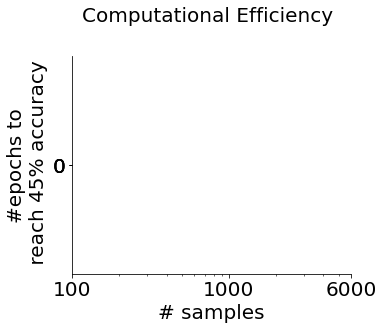

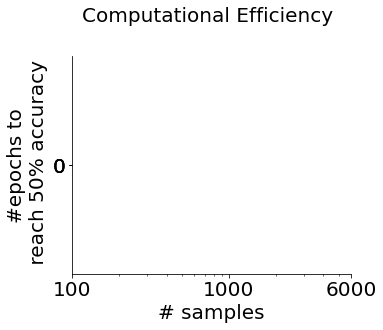

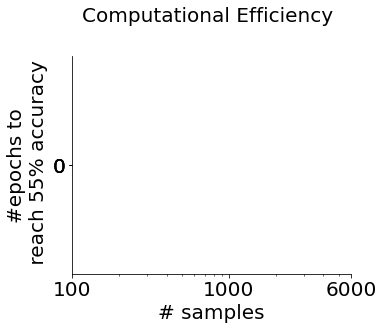

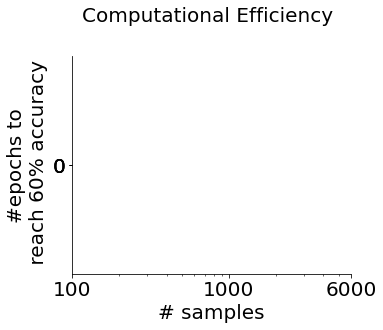

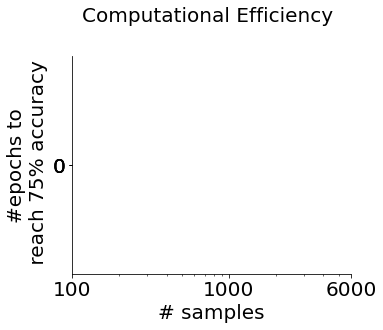

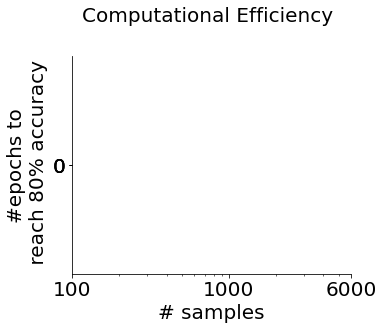

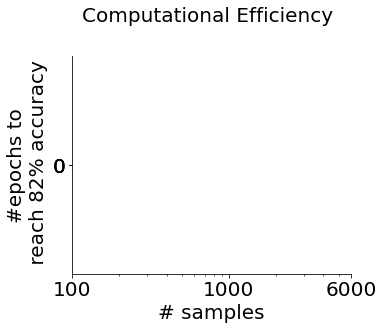

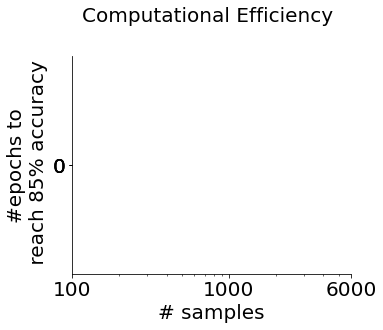

In [70]:
# acc_cutoff_list=[.5,.6,.75, 0.8, .82, .85]
acc_cutoff_list=[.45,.5,.55,.6,.75, 0.8, .82, .85]
# acc_cutoff_list=[.3,.4,.5,.6]
colName = 'epoch'
doTitle = False
resetType_list = ['posRand']
for resetType in resetType_list:
    flops_smart = get_flops(metrics, doWeightFreeze_list, acc_cutoff_list, resetType_list, 'pretrained', numRun)
    flops_dumb = get_flops(metrics, doWeightFreeze_list, acc_cutoff_list, resetType_list, 'vanilla', numRun)
    flops_finetune = get_flops(metrics, doWeightFreeze_list, acc_cutoff_list, resetType_list, 'finetune', numRun)

    fontsize=20
    doExample = False
    x_coord = np.array(sample_size_list)
    xlim=[100, np.max(x_coord)]
    ylim=0
    lineTypeList = ['-', '--']
    lineType = '-'
    color_list = ['r'] + [distinct_clr_5[ii] for ii in [2,1,0]]

    for acc_cutoff in acc_cutoff_list:
        fig = plt.figure(figsize=(5,4))
        thisAx = plt.gca()
    
        for doWeightFreeze, color in zip(doWeightFreeze_list, color_list[:2]):
            if doWeightFreeze:
                typeStr = 'Freeze IN-Polarity'
                typeStr_dict = '\'freeze\''
            else:
                typeStr = 'Fluid IN-Polarity'
                typeStr_dict = '\'liquid\''

            x_mat = flops_smart.query(dict_to_query({'typeStr':typeStr_dict, 'acc':acc_cutoff, 'resetType': '\''+ resetType + '\''}))[colName].tolist()[0]
            plot_median_plus_example(x_mat, x_coord, ylim, xlim, typeStr, doExample, thisAx, color=color, lineType=lineType)

        x_mat = flops_dumb.query(dict_to_query({'typeStr':'\'freeze\'', 'acc':acc_cutoff, 'resetType': '\''+ resetType + '\''}))[colName].tolist()[0]
        plot_median_plus_example(x_mat, x_coord, ylim, xlim, 'Freeze RAND-Polarity', doExample, thisAx, color=color_list[2], lineType=lineType)

        x_mat = flops_dumb.query(dict_to_query({'typeStr':'\'liquid\'', 'acc':acc_cutoff, 'resetType': '\''+ resetType + '\''}))[colName].tolist()[0]
        plot_median_plus_example(x_mat, x_coord, ylim, xlim, 'Fluid RAND-Polarity', doExample, thisAx, color=color_list[3], lineType=lineType)

        simpleaxis(thisAx)
        thisAx.set_xscale('log')
        thisAx.set_xlim(xlim)
        thisAx.set_xticks([100,1000,6000], ['%d' % x for x in [100,1000,6000]], fontsize=fontsize)
        # thisAx.set_xticks([100,5000,50000], ['%d' % x for x in [100,5000,50000]], fontsize=fontsize)

        y_min, y_max = thisAx.get_ylim()
        thisAx.set_yticks([0,round(y_max, -1)/2,round(y_max, -1)], ['%d' % x for x in [0,round(y_max, -1)/2,round(y_max, -1)]], fontsize=fontsize)
        thisAx.set_xlabel('# samples', fontsize=fontsize)
        thisAx.set_ylabel('#'+colName+'s to\n reach %d%% accuracy' % int(acc_cutoff*100), fontsize=fontsize)

        if doTitle:
            y_min, y_max = thisAx.get_ylim()
            thisAx.text(100, y_max*1.05, resetType,fontweight="bold",fontsize=fontsize, ha='center')

        handles, labels = thisAx.get_legend_handles_labels()
        fig.text(0.5,1,'Computational Efficiency', ha='center', fontsize=fontsize)

        # by_label = {labels[i]:handles[i] for i in [0,2,1]}
        # lgd = thisAx.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1,.99), fancybox=True, framealpha=0, fontsize=25)
        plt.savefig(os.path.join(os.getcwd(), 'computational_efficiency_%1.2f.png' % acc_cutoff), dpi=400, bbox_inches = 'tight')

#### Below cell plot for Supp Figure 3 third column

[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]


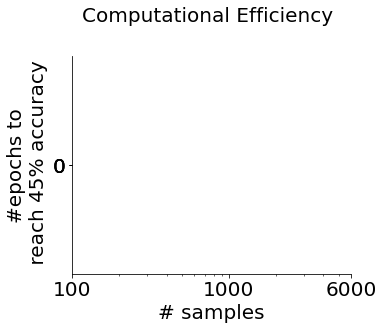

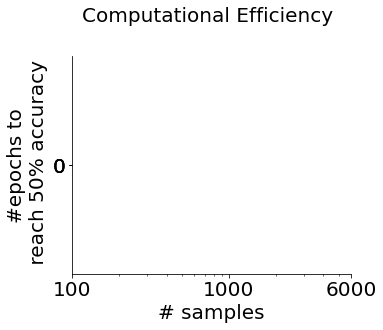

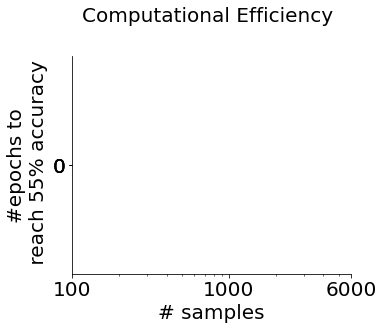

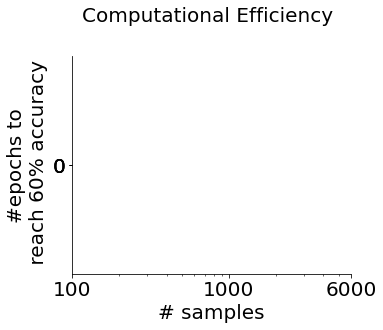

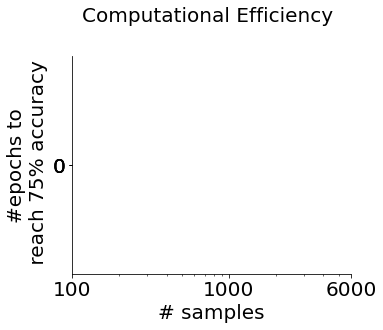

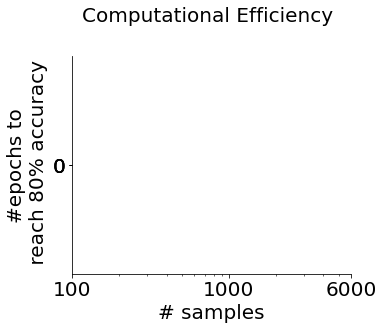

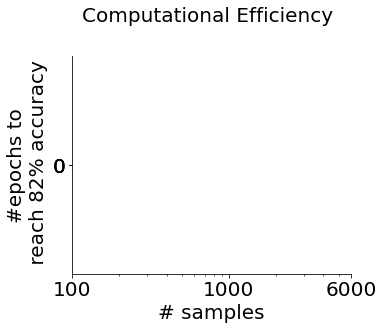

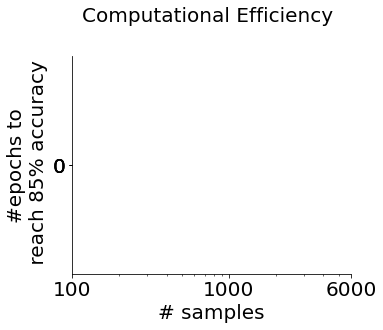

In [71]:
# acc_cutoff_list=[.5,.6,.75, 0.8, .82, .85]
acc_cutoff_list=[.45,.5,.55,.6,.75, 0.8, .82, .85]
# acc_cutoff_list=[.3,.4,.5,.6]
colName = 'epoch'
doTitle = False
resetType_list = ['posRand']
for resetType in resetType_list:
    flops_smart = get_flops(metrics, doWeightFreeze_list, acc_cutoff_list, resetType_list, 'pretrained', numRun)
    flops_dumb = get_flops(metrics, doWeightFreeze_list, acc_cutoff_list, resetType_list, 'vanilla', numRun)
    flops_finetune = get_flops(metrics, doWeightFreeze_list, acc_cutoff_list, resetType_list, 'finetune', numRun)

    fontsize=20
    doExample = False
    x_coord = np.array(sample_size_list)
    xlim=[100, np.max(x_coord)]
    ylim=0
    lineTypeList = ['-', '--']
    lineType = '-'
    color_list = ['r'] + [distinct_clr_5[ii] for ii in [2,3,4]]
    
    for acc_cutoff in acc_cutoff_list:
        fig = plt.figure(figsize=(5,4))
        thisAx = plt.gca()
    
        for didx, doWeightFreeze in enumerate(doWeightFreeze_list):
            if doWeightFreeze:
                typeStr = 'Freeze'
                typeStr_dict = '\'freeze\''
            else:
                typeStr = 'Fluid'
                typeStr_dict = '\'liquid\''

            x_mat = flops_smart.query(dict_to_query({'typeStr':typeStr_dict, 'acc':acc_cutoff, 'resetType': '\''+ resetType + '\''}))[colName].tolist()[0]
            plot_median_plus_example(x_mat, x_coord, ylim, xlim, typeStr+' IN-Polarity', doExample, thisAx, color=color_list[didx], lineType=lineType)
            x_mat = flops_finetune.query(dict_to_query({'typeStr':typeStr_dict, 'acc':acc_cutoff, 'resetType': '\''+ resetType + '\''}))[colName].tolist()[0]
            plot_median_plus_example(x_mat, x_coord, ylim, xlim, typeStr+' IN-Weight', doExample, thisAx, color=color_list[didx+2], lineType='--')

        simpleaxis(thisAx)
        thisAx.set_xscale('log')
        thisAx.set_xlim(xlim)
        thisAx.set_xticks([100,1000,6000], ['%d' % x for x in [100,1000,6000]], fontsize=fontsize)
        # thisAx.set_xticks([100,5000,50000], ['%d' % x for x in [100,5000,50000]], fontsize=fontsize)

        y_min, y_max = thisAx.get_ylim()
        thisAx.set_yticks([0,round(y_max, -1)/2,round(y_max, -1)], ['%d' % x for x in [0,round(y_max, -1)/2,round(y_max, -1)]], fontsize=fontsize)
        thisAx.set_xlabel('# samples', fontsize=fontsize)
        thisAx.set_ylabel('#'+colName+'s to\n reach %d%% accuracy' % int(acc_cutoff*100), fontsize=fontsize)

        if doTitle:
            y_min, y_max = thisAx.get_ylim()
            thisAx.text(100, y_max*1.05, resetType,fontweight="bold",fontsize=fontsize, ha='center')

        handles, labels = thisAx.get_legend_handles_labels()
        fig.text(0.5,1,'Computational Efficiency', ha='center', fontsize=fontsize)

        # by_label = {labels[i]:handles[i] for i in [0,2,3,1]}
        # lgd = thisAx.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1,.99), fancybox=True, framealpha=0, fontsize=25)
        plt.savefig(os.path.join(os.getcwd(), 'computational_efficiency_%1.2f_finetune.png' % acc_cutoff), dpi=400, bbox_inches = 'tight')

#### Below cell plot for Figure 3 third column & Supp Figure A.4

[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan nan nan]
[nan nan n

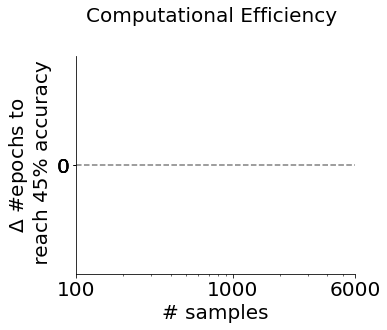

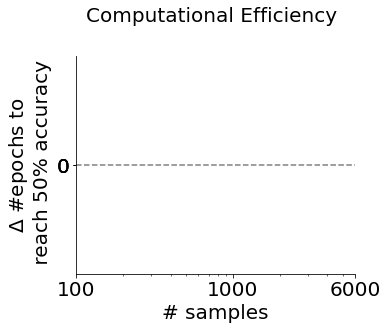

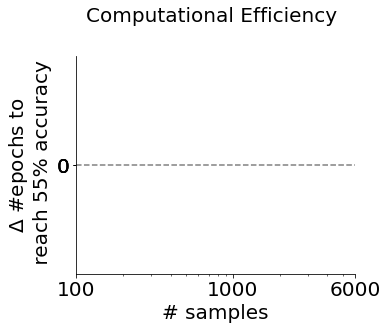

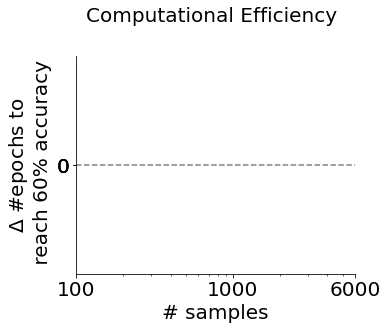

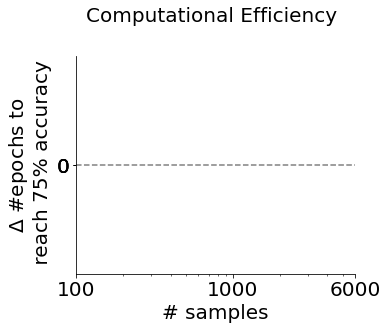

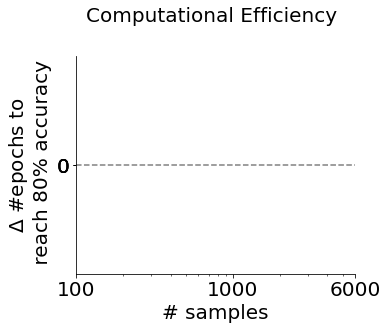

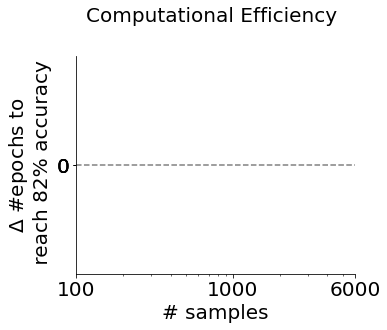

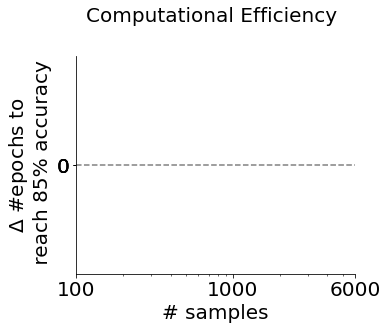

In [72]:
# acc_cutoff_list=[.5,.6,.75, 0.8, .82, .85]
acc_cutoff_list=[.45,.5,.55,.6,.75, 0.8, .82, .85]
# acc_cutoff_list=[.3,.4,.5,.6]
colName = 'epoch'
doTitle = False
resetType_list = ['posRand']
for resetType in resetType_list:
    flops_smart = get_flops(metrics, doWeightFreeze_list, acc_cutoff_list, resetType_list, 'pretrained', numRun)
    flops_dumb = get_flops(metrics, doWeightFreeze_list, acc_cutoff_list, resetType_list, 'vanilla', numRun)
    flops_finetune = get_flops(metrics, doWeightFreeze_list, acc_cutoff_list, resetType_list, 'finetune', numRun)

    fontsize=20
    doExample = False
    x_coord = np.array(sample_size_list)
    xlim=[100, np.max(x_coord)]
    ylim=0
    lineTypeList = ['-', '--']
    lineType = '-'
    color_list = [distinct_clr_5[ii] for ii in [0,2,3,4]]
    
    for acc_cutoff in acc_cutoff_list:
        fig = plt.figure(figsize=(5,4))
        thisAx = plt.gca()

        ######### To correct for multiple comparisons
        plist = []
        base_line = flops_smart.query(dict_to_query({'typeStr':'\'freeze\'', 'acc':acc_cutoff, 'resetType': '\''+ resetType + '\''}))[colName].tolist()[0]

        y_mat = flops_dumb.query(dict_to_query({'typeStr':'\'liquid\'', 'acc':acc_cutoff, 'resetType': '\''+ resetType + '\''}))[colName].tolist()[0]
        test_stat = mannwhitneyu((1-base_line)*100, (1-y_mat)*100, axis = 0, alternative = 'two-sided', nan_policy = 'omit') #
        plist.append(test_stat.pvalue)

        y_mat = flops_smart.query(dict_to_query({'typeStr':'\'liquid\'', 'acc':acc_cutoff, 'resetType': '\''+ resetType + '\''}))[colName].tolist()[0]
        test_stat = mannwhitneyu((1-base_line)*100, (1-y_mat)*100, axis = 0, alternative = 'two-sided', nan_policy = 'omit') #
        plist.append(test_stat.pvalue)

        y_mat = flops_finetune.query(dict_to_query({'typeStr':'\'freeze\'', 'acc':acc_cutoff, 'resetType': '\''+ resetType + '\''}))[colName].tolist()[0]
        test_stat = mannwhitneyu((1-base_line)*100, (1-y_mat)*100, axis = 0, alternative = 'two-sided', nan_policy = 'omit') #
        plist.append(test_stat.pvalue)

        y_mat = flops_finetune.query(dict_to_query({'typeStr':'\'liquid\'', 'acc':acc_cutoff, 'resetType': '\''+ resetType + '\''}))[colName].tolist()[0]
        test_stat = mannwhitneyu((1-base_line)*100, (1-y_mat)*100, axis = 0, alternative = 'two-sided', nan_policy = 'omit') #
        plist.append(test_stat.pvalue)

        pmat = np.stack(plist)
        sort_idx = np.argsort(pmat, axis=0)
        revert_idx = np.argsort(sort_idx, axis=0)
        pvallist = 0.05/np.arange(4,0,-1)
        # print(pvallist)
        sigmat = np.stack([np.cumprod(row[s_idx]<pvallist)[r_idx].astype(bool) for row, s_idx, r_idx in zip(pmat.T, sort_idx.T, revert_idx.T)], axis=1)
            # print(row[s_idx])
            # print(siglist)
            # print(row)
            # print(siglist[r_idx])
        ##########

        base_line = flops_smart.query(dict_to_query({'typeStr':'\'freeze\'', 'acc':acc_cutoff, 'resetType': '\''+ resetType + '\''}))[colName].tolist()[0]

        y_mat = flops_dumb.query(dict_to_query({'typeStr':'\'liquid\'', 'acc':acc_cutoff, 'resetType': '\''+ resetType + '\''}))[colName].tolist()[0]
        plot_diff_plus_mannwhitneyu(base_line, y_mat, x_coord, ylim, xlim, 'Fluid RAND-Polarity', thisAx, siglist = sigmat[0,:], color=color_list[0], linewidth=4)

        y_mat = flops_smart.query(dict_to_query({'typeStr':'\'liquid\'', 'acc':acc_cutoff, 'resetType': '\''+ resetType + '\''}))[colName].tolist()[0]
        plot_diff_plus_mannwhitneyu(base_line, y_mat, x_coord, ylim, xlim, 'Fluid IN-Polarity', thisAx, siglist = sigmat[1,:], color=color_list[1], linewidth=4)

        y_mat = flops_finetune.query(dict_to_query({'typeStr':'\'freeze\'', 'acc':acc_cutoff, 'resetType': '\''+ resetType + '\''}))[colName].tolist()[0]
        plot_diff_plus_mannwhitneyu(base_line, y_mat, x_coord, ylim, xlim, 'Freeze IN-Weight', thisAx, siglist = sigmat[2,:], color=color_list[2], linewidth=4, lineType='--')

        y_mat = flops_finetune.query(dict_to_query({'typeStr':'\'liquid\'', 'acc':acc_cutoff, 'resetType': '\''+ resetType + '\''}))[colName].tolist()[0]
        plot_diff_plus_mannwhitneyu(base_line, y_mat, x_coord, ylim, xlim, 'Fluid IN-Weight', thisAx, siglist = sigmat[3,:], color=color_list[3], linewidth=4, lineType='--')

        # plt.plot([100,50000], [0,0], '--', color=[.5,.5,.5])
        plt.plot([100,6000], [0,0], '--', color=[.5,.5,.5])

        simpleaxis(thisAx)
        thisAx.set_xscale('log')
        thisAx.set_xlim(xlim)
        thisAx.set_xticks([100,1000,6000], ['%d' % x for x in [100,1000,6000]], fontsize=fontsize)
        # thisAx.set_xticks([100,5000,50000], ['%d' % x for x in [100,5000,50000]], fontsize=fontsize)

        y_min, y_max = thisAx.get_ylim()
        thisAx.set_yticks([0,round(y_max, -1)/2,round(y_max, -1)], ['%d' % x for x in [0,round(y_max, -1)/2,round(y_max, -1)]], fontsize=fontsize)
        thisAx.set_xlabel('# samples', fontsize=fontsize)
        thisAx.set_ylabel('$\Delta$ #'+colName+'s to\n reach %d%% accuracy' % int(acc_cutoff*100), fontsize=fontsize)

        if doTitle:
            y_min, y_max = thisAx.get_ylim()
            thisAx.text(100, y_max*1.05, resetType,fontweight="bold",fontsize=fontsize, ha='center')

        handles, labels = thisAx.get_legend_handles_labels()
        fig.text(0.5,1,'Computational Efficiency', ha='center', fontsize=fontsize)

        # by_label = {labels[i]:handles[i] for i in [0,2,3,1]}
        # lgd = thisAx.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1,.99), fancybox=True, framealpha=0, fontsize=25)
        plt.savefig(os.path.join(os.getcwd(), 'computational_efficiency_diff_%1.2f_finetune.png' % acc_cutoff), dpi=400, bbox_inches = 'tight')

### 5.**PROBABILITY** - Figure 2&3 second column

#### Load func

In [73]:
def get_prob_sim(metrics, numRun, typeStr, sample_size_list, acc_cutoff):
    return np.stack([[np.sum(np.any(this_metric>acc_cutoff, axis=1))/numRun for this_metric in metrics.query(dict_to_query({'resetType':'\'posRand\'', 'typeStr':'\''+typeStr+'\'', 'train_sample':train_sample}))['validation_acc'].tolist()] for train_sample in sample_size_list])

#### Below cell plot for Figure 2 second column & Supp Figure A.2

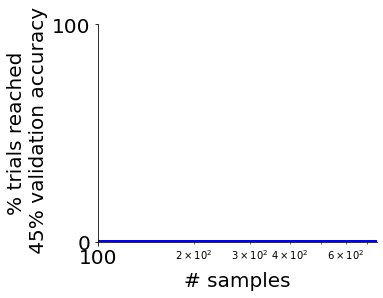

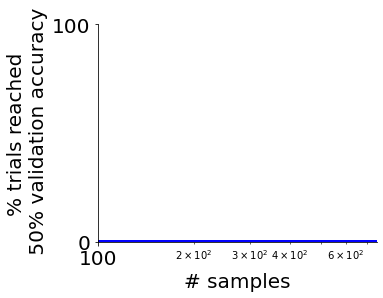

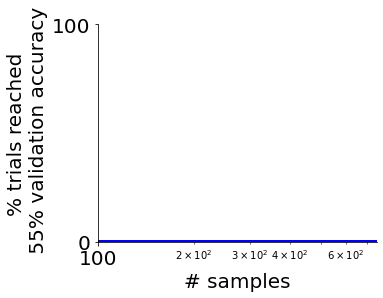

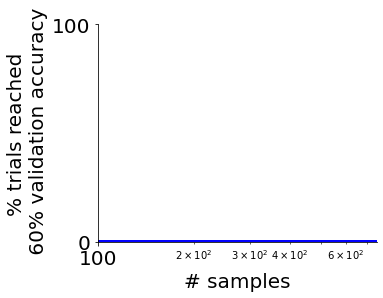

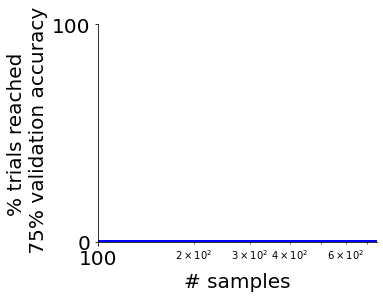

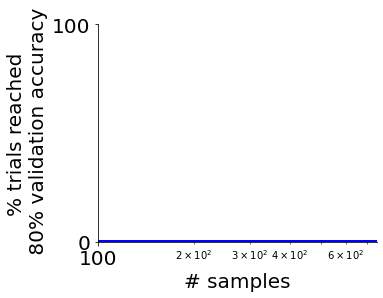

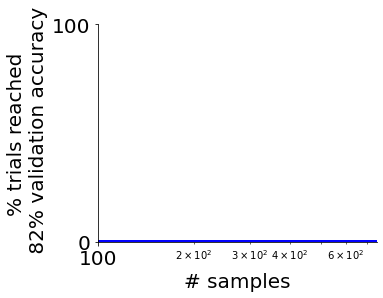

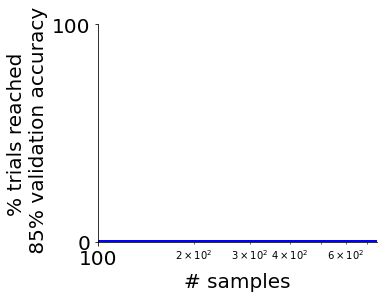

In [74]:
resetType_list = ['posRand']
acc_cutoff_list=[.45,.5,.55,.6,.75, 0.8, .82, .85]
# acc_cutoff_list=[.5,.6,.75, 0.8, .82,.85]
# acc_cutoff_list=[.3,.4,.5,.6]
clr_list = ['r'] + distinct_clr_5

for acc_cutoff in acc_cutoff_list:
    for resetType in resetType_list:
        fig = plt.figure(figsize=(5,4))
        fontsize=20
        x_l = sample_size_list

        y_l = {}
        y_l['Freeze_informed'] = [np.sum(np.any(this_metric>acc_cutoff, axis=1))/numRun for this_metric in metrics.query(dict_to_query({'networkType':'\'pretrained\'', 'resetType':'\''+resetType+'\'', 'typeStr':'\'freeze\''}))['validation_acc'].tolist()]
        y_l['Fluid'] = [np.sum(np.any(this_metric>acc_cutoff, axis=1))/numRun for this_metric in metrics.query(dict_to_query({'networkType':'\'pretrained\'', 'resetType':'\''+resetType+'\'', 'typeStr':'\'liquid\''}))['validation_acc'].tolist()]

        plt.plot(x_l, np.array(y_l['Freeze_informed'])*100, label='Freeze IN-Polarity', color=clr_list[0], linewidth=4)
        plt.plot(x_l, np.array(y_l['Fluid'])*100, label='Fluid IN-Polarity', color=clr_list[3], linewidth=4)

        y_l['Freeze_uninformed'] = [np.sum(np.any(this_metric>acc_cutoff, axis=1))/numRun for this_metric in metrics.query(dict_to_query({'networkType':'\'vanilla\'', 'resetType':'\''+resetType+'\'', 'typeStr':'\'freeze\''}))['validation_acc'].tolist()]
        plt.plot(x_l, np.array(y_l['Freeze_uninformed'])*100, label='Freeze RAND-Polarity', color=clr_list[2], linewidth=4)

        y_l['Fluid_IN_Polarity'] = [np.sum(np.any(this_metric>acc_cutoff, axis=1))/numRun for this_metric in metrics.query(dict_to_query({'networkType':'\'vanilla\'', 'resetType':'\''+resetType+'\'', 'typeStr':'\'liquid\''}))['validation_acc'].tolist()]
        plt.plot(x_l, np.array(y_l['Fluid_IN_Polarity'])*100, label='Fluid RAND-Polarity', color=clr_list[1], linewidth=4)

        plt.xlabel('# samples', fontsize=fontsize)
        plt.ylabel('%% trials reached\n %d%% validation accuracy' % int(acc_cutoff*100), fontsize=fontsize)

        plt.gca().set_xscale('log')
        # plt.gca().set_xticks([100,1000, 6000], ['%d' % x for x in [100,1000, 6000]], fontsize=fontsize)#x_coord
        plt.gca().set_xticks([100,5000, 50000], ['%d' % x for x in [100,5000, 50000]], fontsize=fontsize)#x_coord
        plt.gca().set_xlim([100, max(sample_size_list)])
        plt.yticks([0,100], fontsize=fontsize)
        # plt.grid(True)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        # plt.gca().legend(loc='upper right', bbox_to_anchor=[1,.95], fancybox=True, framealpha=0)
        handles, labels = plt.gca().get_legend_handles_labels()
        rect = plt.gca().patch
        rect.set_alpha(0)
        # fig.text(.5,1,'$P$(learning XOR)', ha='center', fontsize=fontsize)

        # by_label = {labels[i]:handles[i] for i in [0,1,2]}
        # lgd = plt.gca().legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1,.99), fancybox=True, framealpha=0, fontsize=fontsize)
        plt.savefig(os.path.join(os.getcwd(), 'prob_learning_%1.2f.png' % acc_cutoff), dpi=400, bbox_inches = 'tight')

#### Below cell plot for Figure 3 second column & Supp Figure A.3-4

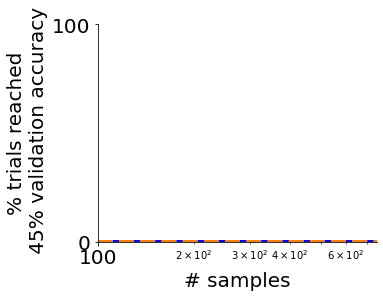

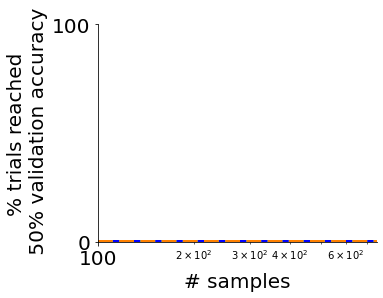

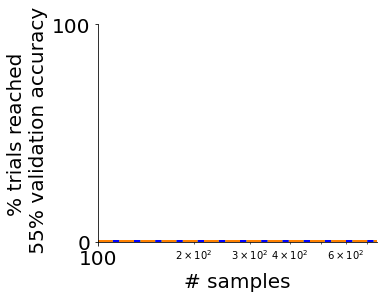

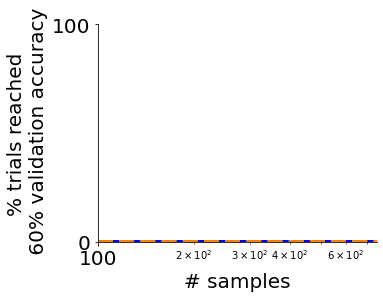

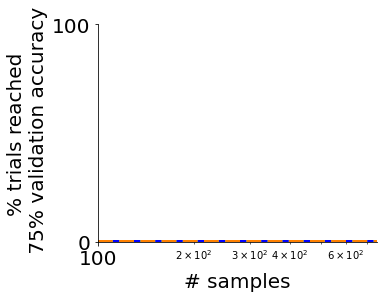

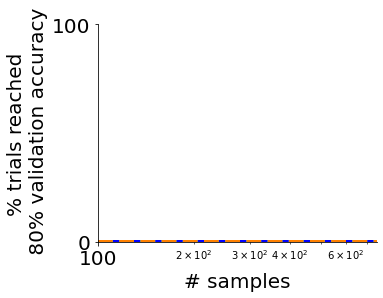

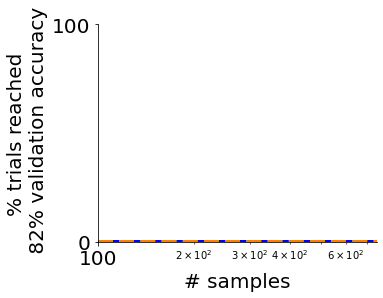

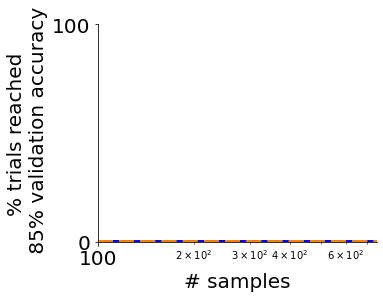

In [75]:
resetType_list = ['posRand']
color_list = ['r'] + [distinct_clr_5[ii] for ii in [0,2,3,4]]
# acc_cutoff_list=[.5,.6,.75, 0.8, .82,.85]
# acc_cutoff_list=[.3,.4,.5,.6]

for acc_cutoff in acc_cutoff_list:
    for resetType in resetType_list:
        fig = plt.figure(figsize=(5,4))
        fontsize=20
        x_l = sample_size_list

        y_l = {}
        y_l['Freeze_informed'] = [np.sum(np.any(this_metric>acc_cutoff, axis=1))/numRun for this_metric in metrics.query(dict_to_query({'networkType':'\'pretrained\'', 'resetType':'\''+resetType+'\'', 'typeStr':'\'freeze\''}))['validation_acc'].tolist()]
        y_l['Fluid'] = [np.sum(np.any(this_metric>acc_cutoff, axis=1))/numRun for this_metric in metrics.query(dict_to_query({'networkType':'\'pretrained\'', 'resetType':'\''+resetType+'\'', 'typeStr':'\'liquid\''}))['validation_acc'].tolist()]

        plt.plot(x_l, np.array(y_l['Freeze_informed'])*100, label='Freeze IN-Polarity', color=color_list[0], linewidth=4)
        plt.plot(x_l, np.array(y_l['Fluid'])*100, label='Fluid IN-Polarity', color=color_list[2], linewidth=4)

        y_l['ctrl'] = [np.sum(np.any(this_metric>acc_cutoff, axis=1))/numRun for this_metric in metrics.query(dict_to_query({'networkType':'\'vanilla\'', 'resetType':'\''+resetType+'\'', 'typeStr':'\'liquid\''}))['validation_acc'].tolist()]
        plt.plot(x_l, np.array(y_l['ctrl'])*100, label='Fluid RAND-Polarity', color=color_list[1], linewidth=4)

        y_l['Freeze_finetune'] = [np.sum(np.any(this_metric>acc_cutoff, axis=1))/numRun for this_metric in metrics.query(dict_to_query({'networkType':'\'finetune\'', 'resetType':'\''+resetType+'\'', 'typeStr':'\'freeze\''}))['validation_acc'].tolist()]
        y_l['Fluid_finetune'] = [np.sum(np.any(this_metric>acc_cutoff, axis=1))/numRun for this_metric in metrics.query(dict_to_query({'networkType':'\'finetune\'', 'resetType':'\''+resetType+'\'', 'typeStr':'\'liquid\''}))['validation_acc'].tolist()]
        plt.plot(x_l, np.array(y_l['Freeze_finetune'])*100, label='Freeze IN-Weight', color=color_list[3], linestyle = '--', linewidth=4)
        plt.plot(x_l, np.array(y_l['Fluid_finetune'])*100, label='Fluid IN-Weight', color=color_list[4], linestyle = '--', linewidth=4)

        plt.xlabel('# samples', fontsize=fontsize)
        plt.ylabel('%% trials reached\n %d%% validation accuracy' % int(acc_cutoff*100), fontsize=fontsize)

        plt.gca().set_xscale('log')
        # plt.gca().set_xticks([100,1000, 6000], ['%d' % x for x in [100,1000, 6000]], fontsize=fontsize)#x_coord
        plt.gca().set_xticks([100,5000, 50000], ['%d' % x for x in [100,5000, 50000]], fontsize=fontsize)#x_coord
        plt.yticks([0,100], fontsize=fontsize)
        plt.gca().set_xlim([100, max(sample_size_list)])
        # plt.grid(True)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        # plt.gca().legend(loc='upper right', bbox_to_anchor=[1,.95], fancybox=True, framealpha=0)
        handles, labels = plt.gca().get_legend_handles_labels()
        rect = plt.gca().patch
        rect.set_alpha(0)
        # fig.text(.5,1,'$P$(learning XOR)', ha='center', fontsize=fontsize)

        # by_label = {labels[i]:handles[i] for i in [0,1,2,3]}
        # lgd = plt.gca().legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1,.99), fancybox=True, framealpha=0, fontsize=fontsize)
        plt.savefig(os.path.join(os.getcwd(), 'prob_learning_%1.2f_finetune.png' % acc_cutoff), dpi=400, bbox_inches = 'tight')